In [1]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")
df_all = pd.concat([df, df_test])

In [2]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [3]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

### Language Model

#### Train on an additional economic corpus

extra datasets for better language model:
https://github.com/philipperemy/financial-news-dataset
Ding et al. (2014)

In [4]:
n_to_read = 500000 #500 000
df_econ = pd.read_csv('data/out.zip', compression='zip', header=0, sep=',', quotechar='"')[-n_to_read:]
print(df_econ.shape)
df_econ.head()

(500000, 1)


,title
8056325,/A M E N D M E N T -- Rogers Communications Inc./
8056326,Moody's rates Gas Natural Ban SA B2/A1.ar
8056327,FACTBOX-Country by country spread of new flu strain
8056328,/A M E N D M E N T -- Rogers Communications Inc./
8056329,Research and Markets: Rural Economy Market Assessment 2009


In [5]:
data_econ = TextDataLoaders.from_df(df_econ, is_lm=True, valid_pct = 0.1, text_col='title')
print(len(data_econ.vocab))
learn = language_model_learner(data_econ, AWD_LSTM, pretrained = True, drop_mult=0.5, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

57472


In [6]:
#learn.lr_find() #lr_steep=0.083176

In [7]:
print(gen_sentence("The company launched with"))

The company launched with Princess Diana , Princess Diana , as a part of the Queen 's Trail Zone in January 2010 . The company sought to get a new company and an Australian - born woman , Princess Diana , went

The company launched with Costello and -mayor in September 1991 , in June 1991 , Yougov took over the most recent Russian - American film production of The Great American . In addition to the companies , Universal Pictures has also


In [8]:
#learn.fit_one_cycle(1, 8e-2) #0.491
learn.fit(n_epoch=200, lr=5e-2, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.880517,3.744575,0.445708,42.291019,11:09
1,3.881540,3.754494,0.444958,42.712608,11:09
2,3.906087,3.765948,0.443759,43.204628,11:09
3,3.885967,3.757897,0.445119,42.858208,11:09
4,3.876885,3.752264,0.443665,42.617481,11:10
5,3.890933,3.748998,0.446112,42.478485,11:10


No improvement since epoch 0: early stopping


In [9]:
#learn.save_encoder('lm_econ_nightly_head')

In [10]:
learn.unfreeze()

In [11]:
#learn.lr_find() #lr_steep=9.999999747378752e-06

In [12]:
#learn.fit_one_cycle(5, 3e-5) #0.483
learn.fit(n_epoch=200, lr=slice(5e-3/(2.6**4),5e-3), cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5))
learn.freeze()
#learn.save_encoder('lm_econ_nightly_body')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.718664,3.636420,0.457434,37.955692,12:00
1,3.604861,3.556891,0.465109,35.054050,12:00
2,3.563644,3.522363,0.468514,33.864353,12:02
3,3.538484,3.508766,0.469745,33.407017,12:02
4,3.558725,3.506741,0.469887,33.339439,12:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.530643,3.475785,0.472907,32.323177,11:58
1,3.483667,3.450924,0.475445,31.529524,11:58
2,3.461323,3.429960,0.477726,30.875401,11:58
3,3.455704,3.411174,0.479403,30.300791,11:59
4,3.447353,3.395041,0.480980,29.815889,11:58
5,3.412242,3.380266,0.482523,29.378576,11:59
6,3.397749,3.366369,0.483912,28.973148,12:00
7,3.394393,3.353765,0.485079,28.610243,12:00
8,3.377156,3.342085,0.486390,28.278015,12:00
9,3.375090,3.330967,0.487474,27.965370,11:59


KeyboardInterrupt: 

In [15]:
#learn.save_encoder('lm_econ_nightly_body')

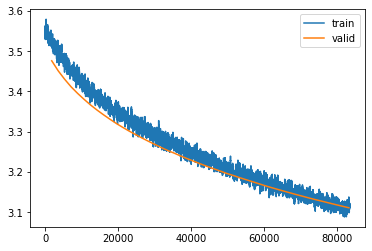

In [13]:
learn.recorder.plot_loss(with_valid = True)

In [14]:
print(gen_sentence("The company launched with"))

The company launched with NAV on Friday , February 15 Allied Estate Properties , Inc . Reports Fourth Quarter and Fiscal Year 2013 Financial Results Statement by the Governor The Zacks Analyst

The company launched with The Jd Capital on Spanish Kingdom South Africa Box Office Research and Markets : Global Partnering for Genetic Management in Clinical Activities Industry 2015 - 2019 Leader of


#### Finetune language model on train and test data
First load our challenge data:

In [25]:
data_lm = TextDataLoaders.from_df(df_all, is_lm=True, text_vocab = data_econ.vocab, valid_pct = 0.1, text_col='text', label_col="sentiment")
print(len(data_lm.vocab)) #

22432


Then let's extend vocab from pretrained economic LM with our new data:

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()
learn.load_encoder('lm_econ')

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.04786301031708717)

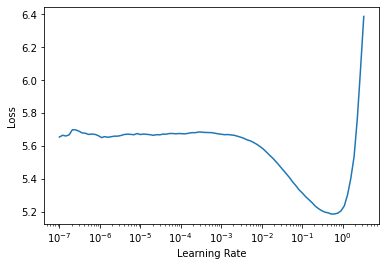

In [27]:
#learn.lr_find() #lr_steep=0.0478630

In [28]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.213995,3.767261,0.325893,43.261421,00:15


In [29]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=3.981071586167673e-06)

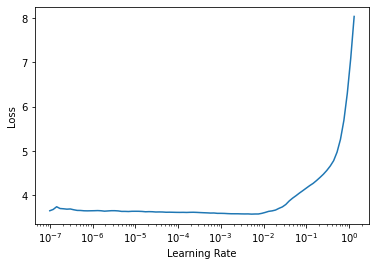

In [30]:
#learn.lr_find() #lr_steep=3.981071586167673e-06

In [31]:
learn.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.477026,3.502283,0.366474,33.191128,00:15


In [32]:
learn.freeze()
learn.save_encoder('lme_finetuned')

#### Check generative performance

In [33]:
print(gen_sentence("The company launched with"))

The company launched with Incap Contract Manufacturing Services , a division of Outotec , the Finnish Outotec Oyj ( OMX : JPM ) said on April 29 , 2008 that it has signed an agreement with Indian Construction Solutions to

The company launched with the St . Petersburg unit , which can be used to comment its financial and operational performance in 2007 . $ aapl this will be a 5 Bears because they are bleeding . Why not . We have a Friday this will be


### Train a Classifier

In [34]:
data_clas = TextDataLoaders.from_df(df, text_col='text', label_col="sentiment", text_vocab=data_lm.vocab)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('lme_finetuned') #also 'finetuned'

In [35]:
#learn.lr_find() # ~ 2e-2

#### Learning
Gradual unfreezing makes a lot of difference!

In [36]:
learn.fit_one_cycle(1, 2e-2) #3
#learn.fit(n_epoch=200, lr=2e-2, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4))

epoch,train_loss,valid_loss,accuracy,time
0,0.782227,0.656955,0.712074,00:03


In [37]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),2e-2)) #2

epoch,train_loss,valid_loss,accuracy,time
0,0.706085,0.624507,0.729618,00:03


In [38]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 2e-2) #2

epoch,train_loss,valid_loss,accuracy,time
0,0.733726,0.645157,0.716202,00:03


In [39]:
#learn.model

In [40]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),2e-2))
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.644127,0.543284,0.787410,00:04
1,0.567262,0.521177,0.792570,00:04


In [41]:
learn.save_encoder('lme_finished')

In [42]:
print("Test Set Accuracy: ",learn.validate()[1]) #0.592 #0.757

Test Set Accuracy:  0.792569637298584


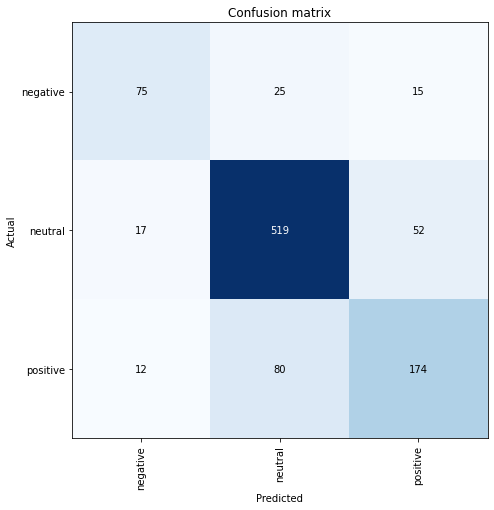

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [44]:
interp.plot_top_losses(6, heatmap=True)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the terms of the financing were approved by the xxmaj annual xxmaj general xxmaj meeting of the xxmaj company held on xxmaj june 30 , 2010 .",positive,neutral,0.974155068397522,5.294873237609863
1,xxbos xxmaj the announcement comes two weeks before a key licensing agreement xxunk between between the two companies which are xxunk in a xxunk over royalty payments for xxmaj texas xxmaj instrument chips which use xxmaj qualcomm - patented technology .,negative,neutral,0.6869989037513733,4.536609172821045
2,"xxbos xxmaj according to preliminary information by the xxmaj finnish xxmaj forest xxmaj industries xxmaj federation , imports of xxunk to xxmaj finland increased to about 20 million m3 in 2005 , representing an increase of 15 % from 2004 .",neutral,positive,0.9704436659812927,4.507889747619629
3,xxbos ` ` xxmaj xxunk aims to expand its distribution network xxunk by increasing the number of concept stores and shop - in - shops .,neutral,positive,0.9793353080749512,3.95800518989563
4,xxbos xxmaj the current reference grade instruments are challenging to operate due to their high price and complexity for routine use .,negative,positive,0.5165815353393555,3.9247372150421143
5,"xxbos ( xxunk ) - xxmaj dec 1 , 2009 - xxmaj finnish xxunk and hand tools maker xxmaj xxunk xxmaj oyj xxmaj xxunk ( xxup xxunk : xxup xxunk ) said today that it will make xxunk a total of 18 office and management staff members of its subsidiary xxmaj xxunk xxmaj group xxmaj ltd . .",negative,neutral,0.8648611307144165,3.783175230026245


### Accuracy on the Test set

In [45]:
data_test = TextDataLoaders.from_df(df_test, text_col='text', label_col="sentiment", text_vocab=data_lm.vocab)
learn_test = text_classifier_learner(data_test, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn_test = learn_test.load_encoder('lme_finished')

In [46]:
print("Test Set Accuracy: ",learn_test.validate()[1]) #0.344

Test Set Accuracy:  0.32551318407058716


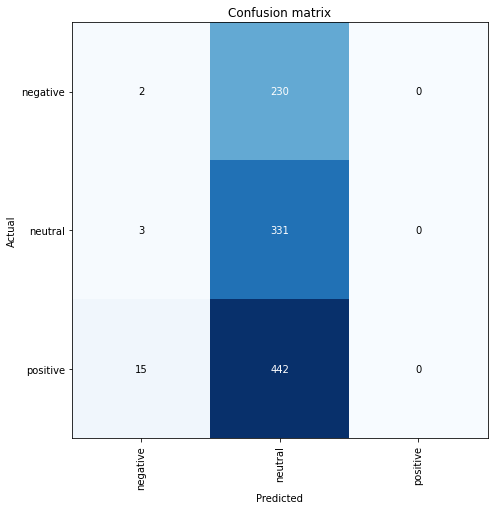

In [47]:
interp = ClassificationInterpretation.from_learner(learn_test)
losses, idxs = interp.top_losses()
len(data_test.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [48]:
interp.plot_top_losses(6, heatmap=True)

,input,target,predicted,probability,loss
0,"xxbos $ xxunk to understand xxmaj xxunk is to understand that its a very diversified company . to make money on all sides of the xxunk supply xxunk machines , reagents / kits and then factor in all of the service contracts they are building for recurring revenue then add to that mix money from xxup nih and xxunk cancer and other stuff at this market cap is a true growth potential small cap . xxmaj on the podcast some time was xxunk on xxunk and i wonder just how big the potential it can unlock xxunk being able to test lots of stuff with 1 test is something attractive to larger companies xxunk in partnership or licensing xxunk",positive,negative,0.35718974471092224,1.2124881744384766
1,"xxbos $ xxunk strong recovery , great to see . i wonder how the xxunk breakdown has changed the last few weeks . xxup xxunk focused money managers would be mad not to take a position now that the trial is xxunk up",positive,neutral,0.36549851298332214,1.2117012739181519
2,"xxbos $ xxunk institutional ownership in excess of 75 % . xxmaj here is why that matters : xxunk contact with management , they know xxunk xxunk going on xxunk analysis for xxup long term hold ( at least a couple years ) xxunk invest with xxmaj institutions , increased confidence backing stock xxmaj xxunk discount this xxunk detail , there is a reason why itâs so high … …",positive,neutral,0.3565044403076172,1.2114675045013428
3,xxbos $ spy $ aapl $ xxunk xxmaj everything xxmaj xxunk doing has a reason in order to win the election . xxmaj xxunk xxmaj biden and now planned to get sick so we market hit xxup ath later when he recovers xxunk,positive,neutral,0.36188217997550964,1.2114083766937256
4,"xxbos $ xxrep 3 q $ amd $ xxunk $ xxunk * * started trading with $ xxunk , down to $ xxunk , back up to $ xxunk . xxmaj big thanks to this community xxunk / xxmaj xxunk",positive,neutral,0.3566295802593231,1.210727572441101
5,"xxbos $ xxunk 68 % xxunk , 10.8 % insider ownership , wow . xxmaj recent offering priced at 2.25 . xxmaj good results on a phase 3 xxmaj plans to submit xxup nda to xxup fda early 2021 . xxmaj drug xxunk really a blockbuster but xxunk like a xxunk safe place to watch money grow till after election .",positive,negative,0.35141628980636597,1.209998369216919


In [49]:
len(data_test.vocab[0]) #22432

22432